In [1]:
from data_preprocess import *
from train_and_test import *
import os
import yaml
from config_loader import *
import pandas as pd

3个实验、3个模型、5个随机种子，共45个模型从4个不同SP开始推理的结果（180条）

In [27]:
dir = model_save_dir
res_save_path = 'exp_results/all_results.csv'
results = []

# 1. 获取数据
norm_data, failure_time = read_and_norm(data_path, rated_capacity, failure_threshold)
_, actual_seq = split_data(norm_data, test_bat)

for filename in os.listdir(dir):
    exp_id, model_name, s_id = parse_model_filename(filename)

    # 2. 加载模型
    model_config = models_config[model_name]
    model_path = os.path.join(dir, filename)
    model = get_model(model_config, device)
    model.load_state_dict(torch.load(model_path, map_location=device))
        
    # 3. 预测：生成预测曲线、计算评价指标
    for sp in start_points:
        pred_seq = predict(model_config, model, sp, actual_seq, seq_length, failure_threshold, device)
        re, rmse, mae = cal_metrics(actual_seq, pred_seq, sp, seq_length, failure_threshold)
        # 4. 保存结果
        results.append({
            'exp_id': exp_id,
            'sp': sp,
            'model': model_name,
            'seed_id': s_id,
            're': re,
            'rmse': rmse,
            'mae': mae,
            'pred_seq': pred_seq
        })

results_df = pd.DataFrame(results).sort_values(by=['exp_id', 'sp', 'model', 'seed_id']).reset_index(drop=True)
results_df.to_csv(res_save_path, index=False)
results_df

/var/folders/6x/w_phznyd4830j7jb8y12rhrc0000gn/T/ipykernel_34235/3994906070.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path,

,exp_id,sp,model,seed_id,re,rmse,mae,pred_seq
0,0,0.0,det,1,0.174727,0.164343,0.123719,"[1.0239859153154736, 1.0237816510236095, 1.023..."
1,0,0.0,det,2,0.102964,0.089476,0.068470,"[1.0239859153154736, 1.0237816510236095, 1.023..."
2,0,0.0,det,3,0.048362,0.064340,0.049077,"[1.0239859153154736, 1.0237816510236095, 1.023..."
3,0,0.0,det,4,1.000000,0.183115,0.114778,"[1.0239859153154736, 1.0237816510236095, 1.023..."
4,0,0.0,det,5,1.000000,0.192360,0.119246,"[1.0239859153154736, 1.0237816510236095, 1.023..."
...,...,...,...,...,...,...,...,...
175,2,0.7,lstm,1,0.015601,0.180383,0.132509,"[1.0239859153154736, 1.0237816510236095, 1.023..."
176,2,0.7,lstm,2,1.000000,0.184923,0.126997,"[1.0239859153154736, 1.0237816510236095, 1.023..."
177,2,0.7,lstm,3,0.235569,0.194168,0.151935,"[1.0239859153154736, 1.0237816510236095, 1.023..."
178,2,0.7,lstm,4,0.285491,0.184460,0.128853,"[1.0239859153154736, 1.0237816510236095, 1.023..."


计算5次重复实验的平均、最佳结果

In [38]:
grouped_save_path = 'exp_results/grouped_results.csv'
grouped_df = results_df.groupby(['exp_id', 'sp', 'model']).agg(
    mean_re=('re', 'mean'),
    mean_rmse=('rmse', 'mean'),
    mean_mae=('mae', 'mean'),
    best_re = ('re', 'min'),
    best_rmse = ('rmse', 'min'),
    best_mae = ('mae', 'min'),
    best_re_sid=('re', lambda x: results_df.loc[x.idxmin(), 'seed_id']),
    best_rmse_sid=('rmse', lambda x: results_df.loc[x.idxmin(), 'seed_id']),
    best_mae_sid=('mae', lambda x: results_df.loc[x.idxmin(), 'seed_id'])
)
grouped_df['best_sids'] = grouped_df.apply(
    lambda row: sorted(set(map(int, [row['best_re_sid'], row['best_rmse_sid'], row['best_mae_sid']]))),
    axis=1
)
grouped_df['mean_pred_seq'] = results_df.groupby(['exp_id', 'sp', 'model'])['pred_seq'].apply(
    lambda x: np.mean(np.array(x.tolist()), axis=0)
)
grouped_df = grouped_df.reset_index()
grouped_df.to_csv(grouped_save_path, index=False)
grouped_df

,exp_id,sp,model,mean_re,mean_rmse,mean_mae,best_re,best_rmse,best_mae,best_re_sid,best_rmse_sid,best_mae_sid,best_sids,mean_pred_seq
0,0,0.0,det,0.465211,0.138727,0.095058,0.048362,0.064340,0.049077,3,3,3,[3],"[1.0239859153154736, 1.0237816510236095, 1.023..."
1,0,0.0,gru,0.712012,0.201705,0.133467,0.263651,0.129519,0.069932,2,2,2,[2],"[1.0239859153154736, 1.0237816510236095, 1.023..."
2,0,0.0,lstm,0.672699,0.150678,0.092025,0.135725,0.096342,0.054018,1,1,1,[1],"[1.0239859153154736, 1.0237816510236095, 1.023..."
3,0,0.3,det,0.352574,0.159313,0.119433,0.068643,0.088271,0.072113,3,3,3,[3],"[1.0239859153154736, 1.0237816510236095, 1.023..."
4,0,0.3,gru,0.703588,0.212429,0.147961,0.251170,0.141388,0.081425,5,2,2,"[2, 5]","[1.0239859153154736, 1.0237816510236095, 1.023..."
5,0,0.3,lstm,0.657410,0.157905,0.102768,0.051482,0.068829,0.048763,1,1,1,[1],"[1.0239859153154736, 1.0237816510236095, 1.023..."
6,0,0.5,det,0.120749,0.107028,0.085339,0.031201,0.064955,0.048454,3,3,4,"[3, 4]","[1.0239859153154736, 1.0237816510236095, 1.023..."
7,0,0.5,gru,0.674259,0.202894,0.145667,0.160686,0.142937,0.096039,5,5,2,"[2, 5]","[1.0239859153154736, 1.0237816510236095, 1.023..."
8,0,0.5,lstm,0.660842,0.175655,0.119712,0.026521,0.064349,0.051396,1,1,1,[1],"[1.0239859153154736, 1.0237816510236095, 1.023..."
9,0,0.7,det,0.169111,0.112752,0.088477,0.034321,0.029028,0.020721,1,1,1,[1],"[1.0239859153154736, 1.0237816510236095, 1.023..."


平均预测曲线

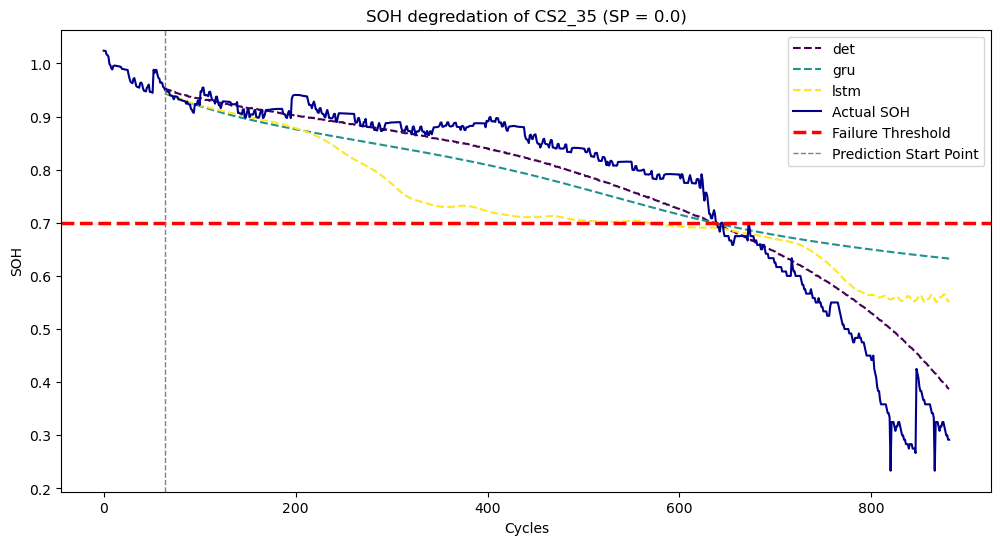

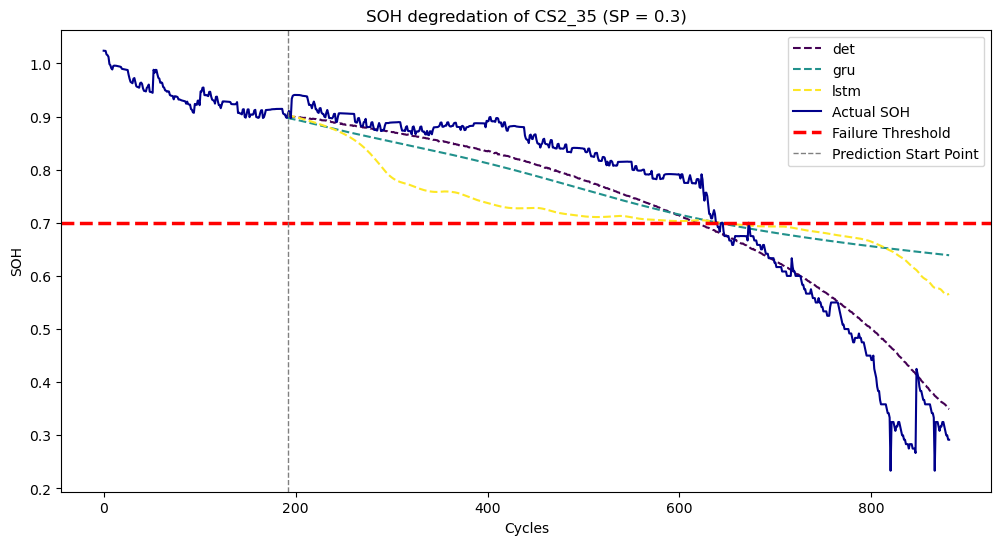

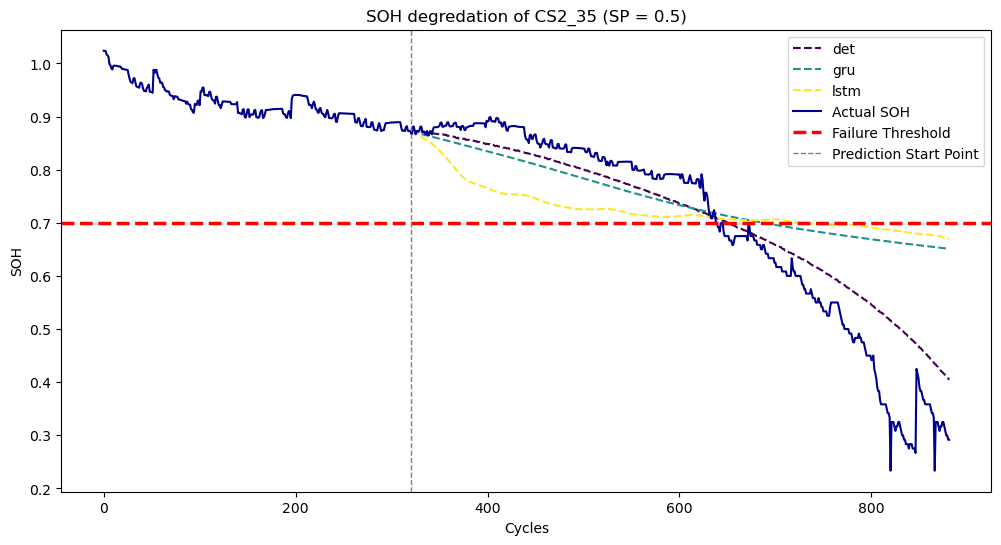

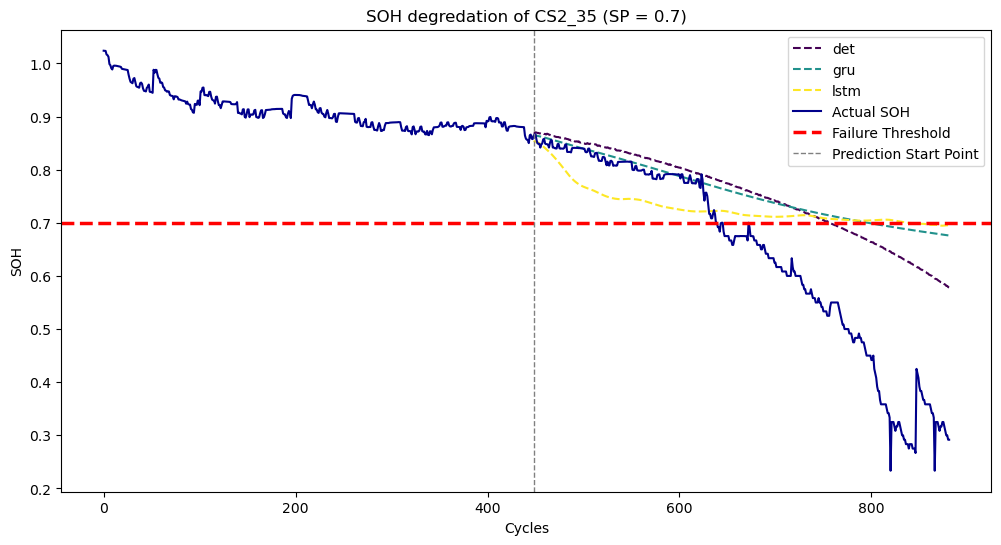

In [42]:
exp_id = 2
for sp in start_points:
    pred_seqs = {}
    df = grouped_df[(grouped_df['exp_id'] == exp_id) & (grouped_df['sp'] == sp)]
    model_names, seqs = df['model'], df['mean_pred_seq']
    for model_name, seq in zip(model_names, seqs):
        pred_seqs[model_name] = seq
    plot(actual_seq, pred_seqs, sp, failure_threshold, seq_length, test_bat)

最佳预测曲线

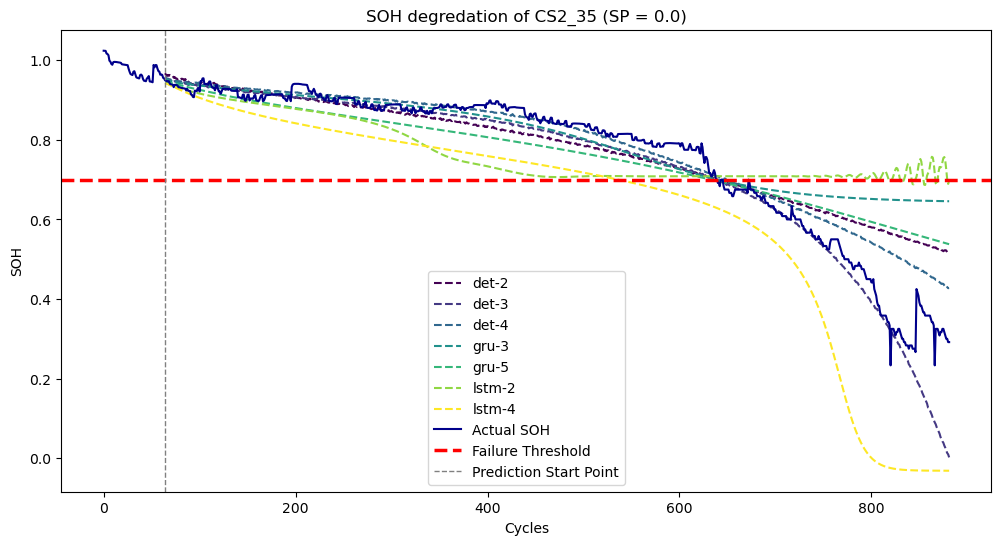

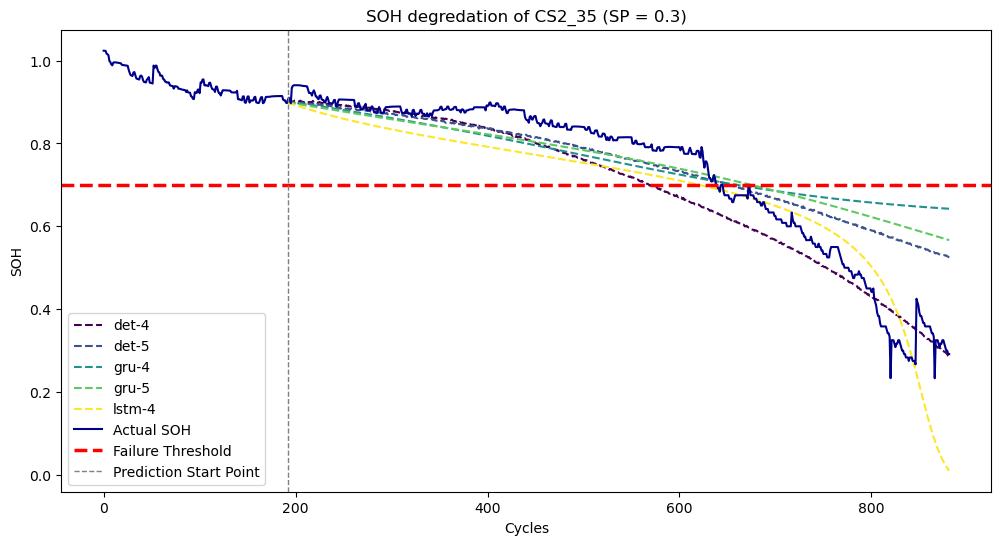

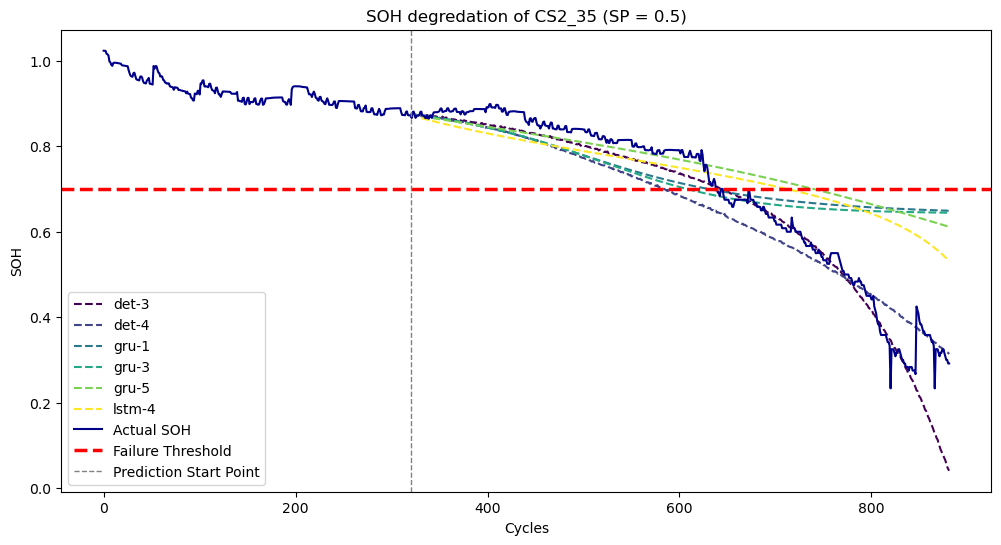

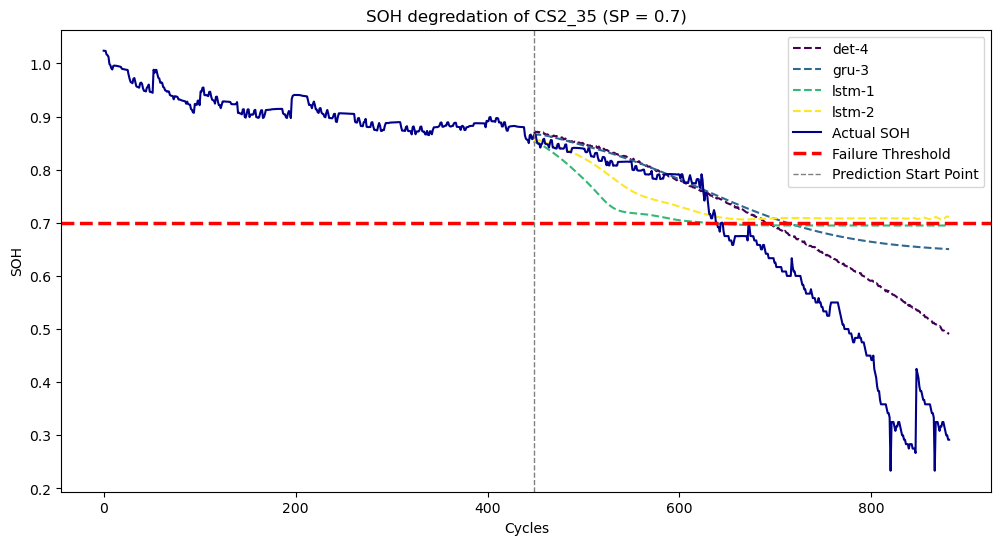

In [56]:
exp_id = 2

for sp in start_points:
    df = results_df[(results_df['exp_id'] == exp_id) & (results_df['sp'] == sp)]
    model_names = grouped_df[(grouped_df['exp_id'] == exp_id) & (grouped_df['sp'] == sp)]['model']
    best_sids_list = grouped_df[(grouped_df['exp_id'] == exp_id) & (grouped_df['sp'] == sp)]['best_sids']
    
    pred_seqs = {}
    for model_name, best_sids in zip(model_names, best_sids_list):
        for sid in best_sids:
            model_label = model_name + f'-{sid}'
            pred_seqs[model_label] = df[(df['model'] == model_name) & (df['seed_id'] == sid)]['pred_seq'].iloc[0]

    plot(actual_seq, pred_seqs, sp, failure_threshold, seq_length, test_bat)

各实验效果对比

In [60]:
df = grouped_df.sort_values(by=['model', 'sp', 'exp_id']).reset_index(drop=True)
front_columns = ['model', 'sp', 'exp_id']
other_columns = [col for col in df.columns if col not in front_columns]
df = df[front_columns + other_columns]
df.to_csv('exp_results/exp_cmp.csv', index=False)
df

,model,sp,exp_id,mean_re,mean_rmse,mean_mae,best_re,best_rmse,best_mae,best_re_sid,best_rmse_sid,best_mae_sid,best_sids,mean_pred_seq
0,det,0.0,0,0.465211,0.138727,0.095058,0.048362,0.064340,0.049077,3,3,3,[3],"[1.0239859153154736, 1.0237816510236095, 1.023..."
1,det,0.0,1,0.018409,0.043326,0.032975,0.001560,0.037770,0.025571,1,5,2,"[1, 2, 5]","[1.0239859153154736, 1.0237816510236095, 1.023..."
2,det,0.0,2,0.015289,0.070247,0.046274,0.000000,0.056328,0.031625,2,4,3,"[2, 3, 4]","[1.0239859153154736, 1.0237816510236095, 1.023..."
3,det,0.3,0,0.352574,0.159313,0.119433,0.068643,0.088271,0.072113,3,3,3,[3],"[1.0239859153154736, 1.0237816510236095, 1.023..."
4,det,0.3,1,0.052730,0.078017,0.060934,0.017161,0.041981,0.033401,3,3,3,[3],"[1.0239859153154736, 1.0237816510236095, 1.023..."
5,det,0.3,2,0.047738,0.086084,0.061179,0.017161,0.060403,0.050873,5,4,4,"[4, 5]","[1.0239859153154736, 1.0237816510236095, 1.023..."
6,det,0.5,0,0.120749,0.107028,0.085339,0.031201,0.064955,0.048454,3,3,4,"[3, 4]","[1.0239859153154736, 1.0237816510236095, 1.023..."
7,det,0.5,1,0.073635,0.086053,0.065582,0.037441,0.047895,0.043142,5,5,5,[5],"[1.0239859153154736, 1.0237816510236095, 1.023..."
8,det,0.5,2,0.063651,0.090853,0.062539,0.004680,0.058311,0.035268,3,4,3,"[3, 4]","[1.0239859153154736, 1.0237816510236095, 1.023..."
9,det,0.7,0,0.169111,0.112752,0.088477,0.034321,0.029028,0.020721,1,1,1,[1],"[1.0239859153154736, 1.0237816510236095, 1.023..."
